<a href="https://colab.research.google.com/github/frnunez/SU-Grad-Portfolio/blob/master/IST%20718%20-%20Big%20Data%20Analytics/IST%20718%20-%20Lab%201%20-%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCAA FOOTBALL SALARY RECOMMENDATIONS

In [0]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns #seaborn for plotting
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Coaches Data


In [0]:
# read in Coaches data
coaches = pd.read_csv("https://github.com/frnunez/SU-IST-718/raw/master/data/Coaches9.csv")
coaches.sort_values('School', inplace=True, ascending=True)

# compute descriptive statistics for original variables
print(coaches.describe())

#check for null values in the dataframe
print("*"*80)
are_null_values = coaches.isnull().values.any()
num_nulls = coaches.isnull().sum()
print("Are there any null values?",are_null_values)
print("*"*80)
print("Columns with null values:\n",num_nulls)
print("Number of observations:\n",len(coaches))

                School Conference       Coach  ... BonusPaid AssistantPay Buyout
count              129        129         129  ...       129          129    129
unique             129         11         129  ...        51            1    102
top     San Jose State    Big Ten  Sean Lewis  ...        --          $0      --
freq                 1         14           1  ...        41          129     22

[4 rows x 9 columns]
********************************************************************************
Are there any null values? False
********************************************************************************
Columns with null values:
 School          0
Conference      0
Coach           0
SchoolPay       0
TotalPay        0
Bonus           0
BonusPaid       0
AssistantPay    0
Buyout          0
dtype: int64
Number of observations:
 129


In [0]:
coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


In [0]:
# Clean up: convert dollar amounts from object to numeric
# Code Courtesy of Allan Flores

# Set a function to clean the data
# Function replaces commas, dollar signs, extra spaces, and dashes for numeric variables
# Function also replaces NaN with 0
def cleaner(data_column):
    col = data_column.str.replace(',','')
    col = col.str.replace('$','')
    col = col.str.replace(" ","")
    col = col.str.replace("--","0")
    col = col.fillna(0)
    col = col.astype(float)
    return col

# Run the 'cleaner' function for columns of interest
coaches['SchoolPay'] = cleaner(coaches['SchoolPay']) #may not want this one
coaches['TotalPay'] = cleaner(coaches['TotalPay'])
coaches['Bonus'] = cleaner(coaches['Bonus'])
coaches['BonusPaid'] = cleaner(coaches['BonusPaid'])
coaches['AssistantPay'] = cleaner(coaches['AssistantPay']) #may not want this one
coaches['Buyout'] = cleaner(coaches['Buyout']) #may not want this one

coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0


### Webscraping Stadium Capacity Data
##### Curtesy of Syed Nazrul's PokeScraper Tutorial
https://www.youtube.com/watch?list=PLuVTNX0oceI87L2sPUTODZmwn-ORos-9Z&v=egYVP-TeSg8


In [0]:
# Webscrapping curtesy of Syed Nazrul's PokeScraper Tutorial",
# https://www.youtube.com/watch?list=PLuVTNX0oceI87L2sPUTODZmwn-ORos-9Z&v=egYVP-TeSg8",

import requests, six
import lxml.html as lh
from itertools import cycle, islice

#create url
url='https://www.collegegridirons.com/comparisons-by-capacity/'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of the site's HTML code
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:\"%s\"'%(i,name))
    col.append((name,[]))


1:"Stadium"
2:"College"
3:"Conference"
4:"Capacity"
5:"Opened"


In [0]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 5, the //tr data is not from our table 
    if len(T)!=5:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
        
#check to see if data came into all 5 columns
[len(C) for (title,C) in col]

[131, 131, 131, 131, 131]

In [0]:
# create Stadiums df
Dict={title:column for (title,column) in col}
stadiums=pd.DataFrame(Dict)
stadiums.rename(columns={'College':'School'},inplace=True)
stadiums.sort_values('School', inplace=True, ascending=True)

# clean up
stadiums['School'] = stadiums['School'].str.replace('BYU', 'Brigham Young').str.strip()
stadiums['School'] = stadiums['School'].str.replace('UNC Charlotte', 'Charlotte').str.strip()
stadiums['School'] = stadiums['School'].str.replace('Miami', 'Miami (Fla.)').str.strip()
stadiums['School'] = stadiums['School'].str.replace('Miami \\(Fla\\.\\)-OH', 'Miami (Ohio)').str.strip()
stadiums['School'] = stadiums['School'].str.replace('NC State', 'North Carolina State').str.strip()
stadiums['School'] = stadiums['School'].str.replace('SMU', 'Southern Methodist').str.strip()
stadiums['School'] = stadiums['School'].str.replace('Southern Miss', 'Southern Mississippi').str.strip()
stadiums['School'] = stadiums['School'].str.replace('TCU', 'Texas Christian').str.strip()
stadiums['School'] = stadiums['School'].str.replace('UAB', 'Alabama at Birmingham').str.strip()
stadiums['School'] = stadiums['School'].str.replace('UMass', 'Massachusetts').str.strip()
stadiums['School'] = stadiums['School'].str.replace('UNLV', 'Nevada-Las Vegas').str.strip()
stadiums['School'] = stadiums['School'].str.replace('USC', 'Southern California').str.strip()
stadiums['School'] = stadiums['School'].str.replace('UTEP', 'Texas-El Paso').str.strip()
stadiums['School'] = stadiums['School'].str.replace('UTSA', 'Texas-San Antonio').str.strip()
#note umass plays in 2 stadiums

# Run the 'cleaner' function for columns of interest
stadiums['Capacity'] = cleaner(stadiums['Capacity'])

stadiums.head()

,Stadium,School,Conference,Capacity,Opened
58,Falcon Stadium,Air Force,Mountain West,52237.0,1962
107,InfoCision Stadium,Akron,MAC,30000.0,2009
5,Bryant Denny Stadium,Alabama,SEC,101821.0,1929
118,Kidd Brewer Stadium,Appalachian State,Sun Belt,24150.0,1962
50,Arizona Stadium,Arizona,Pac 12,56037.0,1928


### Import Graduation Rates Data
From Bleacher report September 4, 2013 <br>
https://bleacherreport.com/articles/1731218-college-football-schools-with-the-best-and-worst-graduation-rates#slide0

* FGR - Federal Graduation Rate - This method keeps track of first-time freshmen who are full-time students. It follows those students over the course of a six-year period to see if they graduate at the same institution at which they began their secondary education. This method does not account for students who transfer.

* GSR - Graduation Success Rate - Uses the same type of data as the FGR, but the GSR data also takes into account students who transfer into a school and graduate from that same school. It also doesn't count against a school's rate when a student-athlete in good standing transfers out of that institution to attend another.

The 2013 Graduation Rate data was obtained using the 2006 cohort graduation rates for both GSR and FGR

In [0]:
# import graduation rate data
# obtained from https://web3.ncaa.org/aprsearch/gsrsearch
# Sport = Football, Year = 2012-2013

# read in Coaches data and create DF
gradrates = pd.read_csv("https://github.com/frnunez/SU-IST-718/raw/master/data/gradrates.csv")

#Clean Up School Names - Remove "University of"
import re
gradrates['School'] = gradrates['School'].str.replace('The University of ', '').str.strip()
gradrates['School'] = gradrates['School'].str.replace('University of ', '').str.strip()
gradrates['School'] = gradrates['School'].str.replace('University at ', '').str.strip()
gradrates['School'] = gradrates['School'].str.replace(', the State New York', '').str.strip()
gradrates['School'] = gradrates['School'].str.replace('University', '').str.strip()
gradrates['School'] = gradrates['School'].str.replace('U.S. Air Force Academy', 'Air Force').str.strip()
gradrates['School'] = gradrates['School'].str.replace('U.S. Naval Academy', 'Navy').str.strip()
gradrates['School'] = gradrates['School'].str.replace('U.S. Military Academy', 'Army').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Wisconsin-Madison', 'Wisconsin').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Bowling Green State', 'Bowling Green').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Arkansas, Fayetteville', 'Arkansas').str.strip()
gradrates['School'] = gradrates['School'].str.replace('The Ohio State', 'Ohio State').str.strip()
gradrates['School'] = gradrates['School'].str.replace('California, Berkeley', 'California').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Colorado, Boulder', 'Colorado').str.strip()
gradrates['School'] = gradrates['School'].str.replace('California State , Fresno', 'Fresno State').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Georgia Institute of Technology', 'Georgia Tech').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Hawaii, Manoa', 'Hawaii').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Illinois Urbana-Champaign', 'Illinois').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Indiana , Bloomington', 'Indiana').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Louisiana Monroe', 'Louisiana-Monroe').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Louisiana State', 'LSU').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Louisiana at Lafayette', 'Louisiana-Lafayette').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Maryland, College Park', 'Maryland').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Massachusetts, Amherst', 'Massachusetts').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Miami \\(Florida\\)', 'Miami (Fla.)').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Miami  \\(Ohio\\)', 'Miami (Ohio)').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Middle Tennessee State', 'Middle Tennessee').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Minnesota, Twin Cities', 'Minnesota').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Missouri, Columbia', 'Missouri').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Nebraska, Lincoln', 'Nebraska').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Nevada, Las Vegas', 'Nevada-Las Vegas').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Nevada, Reno', 'Nevada').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Pennsylvania State', 'Penn State').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Rutgers, The State New Jersey, New Brunswick', 'Rutgers').str.strip()
gradrates['School'] = gradrates['School'].str.replace('South Carolina, Columbia', 'South Carolina').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Tennessee, Knoxville', 'Tennessee').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Texas at Austin', 'Texas').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Texas at El Paso', 'Texas-El Paso').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Texas A&M , College Station', 'Texas A&M').str.strip()
gradrates['School'] = gradrates['School'].str.replace('Virginia Polytechnic Institute and State', 'Virginia Tech').str.strip()
gradrates['School'] = gradrates['School'].str.replace('North Carolina, Chapel Hill', 'North Carolina').str.strip()
gradrates['School'] = gradrates['School'].str.replace('California, Los Angeles', 'UCLA').str.strip()

# sort alphabeticlly
gradrates.sort_values('School', inplace=True, ascending=True)

# convert State & Conference to categorical
gradrates['State'] = gradrates.State.astype('category')
gradrates['Conference'] = gradrates.Conference.astype('category')

gradrates.head()

,Cohort Year,School,Conference,Sport,State,GSR,FGR
210,2006,Air Force,Mountain West Conference,Football,CO,93,NaN
0,2006,Akron,Mid-American Conference,Football,OH,58,52.0
3,2006,Alabama,Southeastern Conference,Football,AL,73,57.0
1,2006,Alabama A&M,Southwestern Athletic Conf.,Football,AL,40,45.0
2,2006,Alabama State,Southwestern Athletic Conf.,Football,AL,81,59.0


### Win Loss Record

In [0]:
#Scrape 2019 Win-Loss Records

#create url
url='https://www.teamrankings.com/ncf/trends/win_trends/?range=yearly_2019'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of the site's HTML code
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:\"%s\"'%(i,name))
    col.append((name,[]))
    
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 5, the //tr data is not from our table 
    if len(T)!=5:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

1:"Team"
2:"Win-Loss Record"
3:"Win %"
4:"MOV"
5:"ATS +/-"


In [0]:
# create WinLoss dataframe
Dict={title:column for (title,column) in col}
WinLoss=pd.DataFrame(Dict)
WinLoss.rename(columns={'Team':'School'},inplace=True)
WinLoss.rename(columns={'Win %':'WinPercentage2019'},inplace=True)
WinLoss.rename(columns={'Win-Loss Record':'Win-Loss Record2019'},inplace=True)
WinLoss.rename(columns={'ATS +/-':'ATS'},inplace=True)
WinLoss.sort_values('School', inplace=True, ascending=True)

In [0]:
#Clean up

# Convert Win Percentage into a float
WinLoss["WinPer2019"] = WinLoss['WinPercentage2019'].str.replace('%', '').str.strip()
WinLoss["WinPer2019"] = WinLoss.WinPer2019.astype(float)
# using apply function to convert to percentage
WinLoss["WinPer2019"] = WinLoss.apply(lambda row: (row.WinPer2019 * 0.01), axis = 1) 

# Fix Names
WinLoss['School'] = WinLoss['School'].str.replace('App State', 'Appalachian State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Arizona St', 'Arizona State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Arkansas St', 'Arkansas State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('BYU', 'Brigham Young').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Boston Col', 'Boston College').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Bowling Grn', 'Bowling Green').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Central FL', 'Central Florida').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Central Mich', 'Central Michigan').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Coastal Car', 'Coastal Carolina').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Colorado St', 'Colorado State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('E Carolina', 'East Carolina').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('E Michigan', 'Eastern Michigan').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Fla Atlantic', 'Florida Atlantic').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Florida Intl', 'Florida International').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Florida St', 'Florida State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Fresno St', 'Fresno State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('GA Southern', 'Georgia Southern').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('GA Tech', 'Georgia Tech').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Kansas St', 'Kansas State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('LA Lafayette', 'Louisiana-Lafayette').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('LA Tech', 'Louisiana Tech').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('LA Monroe', 'Louisiana-Monroe').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Miami \\(FL\\)', 'Miami (Fla.)').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Miami \\(OH\\)', 'Miami (Ohio)').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Michigan St', 'Michigan State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Middle Tenn', 'Middle Tennessee').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Miss State', 'Mississippi State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('N Carolina', 'North Carolina').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('N Illinois', 'Northern Illinois').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('N Mex State', 'New Mexico State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('NC State', 'North Carolina State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Oklahoma St', 'Oklahoma State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Oregon St', 'Oregon State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('S Alabama', 'South Alabama').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('S Carolina', 'South Carolina').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('S Florida', 'South Florida').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('S Methodist', 'Southern Methodist').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('S Mississippi', 'Southern Mississippi').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('San Diego St', 'San Diego State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('San Jose St', 'San Jose State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('TX Christian', 'Texas Christian').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('TX-San Ant', 'Texas-San Antonio').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('TX El Paso', 'Texas-El Paso').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('U Mass', 'Massachusetts').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('UAB', 'Alabama at Birmingham').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('UNLV', 'Nevada-Las Vegas').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('USC', 'Southern California').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('VA Tech', 'Virginia Tech').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('W Kentucky', 'Western Kentucky').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('W Michigan', 'Western Michigan').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('W Virginia', 'West Virginia').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('Wash State', 'Washington State').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('W Virginia', 'West Virginia').str.strip()
WinLoss['School'] = WinLoss['School'].str.replace('W Virginia', 'West Virginia').str.strip()

WinLoss.head()

,School,Win-Loss Record2019,WinPercentage2019,MOV,ATS,WinPer2019
14,Air Force,11-2-0,84.6%,14.2,+5.7,0.846
129,Akron,0-12-0,0.0%,-25.8,-11.6,0.000
12,Alabama,11-2-0,84.6%,28.6,+0.6,0.846
2,Appalachian State,13-1-0,92.9%,18.8,+4.9,0.929
99,Arizona,4-8-0,33.3%,-8.8,-5.5,0.333


In [0]:
# Merge all dfs to create finalcoaches
merge1 = coaches.merge(stadiums, on='School', how='left') #Add stadium data to coaches, match on School to create merge1
merge2 = merge1.merge(gradrates, on='School', how='left') #Add gradrates data to merge1, match on School to create merge2
finalcoaches = merge2.merge(WinLoss, on='School', how='left') #Add WinLoss data to merge2, match on School to create finalcoaches

#drop uneeded columns
finalcoaches = finalcoaches.drop(['Stadium', 'Conference_y', 'Conference',
                                  'Sport',
                                  'Opened','MOV','ATS'], axis=1)

# rename
finalcoaches.rename(columns={'Conference_x':'Conference'}, inplace=True)

# using apply function to create a new column for graphing purposes (thousands)
finalcoaches['TotalPayThousands'] = finalcoaches.apply(lambda row: (row.TotalPay * 0.001), axis = 1) 

# compute descriptive statistics for original variables
print(finalcoaches.describe())
print("*"*80)
print(finalcoaches.head())

          SchoolPay      TotalPay  ...  WinPer2019  TotalPayThousands
count  1.290000e+02  1.290000e+02  ...  129.000000         129.000000
mean   2.335563e+06  2.342113e+06  ...    0.521217        2342.113140
std    1.898654e+06  1.903114e+06  ...    0.217709        1903.113765
min    0.000000e+00  0.000000e+00  ...    0.000000           0.000000
25%    7.625700e+05  7.625700e+05  ...    0.333000         762.570000
50%    1.800000e+06  1.830000e+06  ...    0.538000        1830.000000
75%    3.550000e+06  3.550000e+06  ...    0.643000        3550.000000
max    8.307000e+06  8.307000e+06  ...    1.000000        8307.000000

[8 rows x 12 columns]
********************************************************************************
                  School Conference  ... WinPer2019  TotalPayThousands
0              Air Force   Mt. West  ...      0.846              885.0
1                  Akron        MAC  ...      0.000              412.5
2                Alabama        SEC  ...      0.846  

In [0]:
#check for null values in the dataframe
are_null_values = finalcoaches.isnull().values.any()
num_nulls = finalcoaches.isnull().sum()
print("*"*80)
print("Are there any null values?",are_null_values)
print("*"*80)
print("Columns with null values: ",num_nulls)
print("Number of observations: ",len(finalcoaches))

********************************************************************************
Are there any null values? True
********************************************************************************
Columns with null values:  School                 0
Conference             0
Coach                  0
SchoolPay              0
TotalPay               0
Bonus                  0
BonusPaid              0
AssistantPay           0
Buyout                 0
Capacity               1
Cohort Year            4
State                  4
GSR                    4
FGR                    8
Win-Loss Record2019    0
WinPercentage2019      0
WinPer2019             0
TotalPayThousands      0
dtype: int64
Number of observations:  129


In [0]:
# Schools missing FGR (Federal Graduation Rate) and GSR (Graduate Success Rate)
finalcoaches[finalcoaches['FGR'].isna()]

# We will use GSR instead of FGR will give us more data and is the method being used by NCAA

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Capacity,Cohort Year,State,GSR,FGR,Win-Loss Record2019,WinPercentage2019,WinPer2019,TotalPayThousands
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,52237.0,2006.0,CO,93.0,NaN,11-2-0,84.6%,0.846,885.000
9,Army,Ind.,Jeff Monken,932521.0,932521.0,0.0,0.0,0.0,0.0,38000.0,2006.0,NY,89.0,NaN,5-8-0,38.5%,0.385,932.521
21,Charlotte,C-USA,Brad Lambert,625000.0,625000.0,120000.0,0.0,0.0,556389.0,15314.0,NaN,NaN,NaN,NaN,7-6-0,53.8%,0.538,625.000
38,Georgia State,Sun Belt,Shawn Elliott,569000.0,569000.0,220000.0,60000.0,0.0,1500000.0,23000.0,NaN,NaN,NaN,NaN,7-6-0,53.8%,0.538,569.000
69,Navy,AAC,Ken Niumatalolo,2163000.0,2163000.0,0.0,0.0,0.0,0.0,34000.0,2006.0,MD,84.0,NaN,11-2-0,84.6%,0.846,2163.000
85,Old Dominion,C-USA,Bobby Wilder,654667.0,654667.0,504895.0,0.0,0.0,1200000.0,20118.0,2006.0,VA,50.0,NaN,1-11-0,8.3%,0.083,654.667
95,South Alabama,Sun Belt,Steve Campbell,600000.0,600000.0,295000.0,0.0,0.0,918333.0,40646.0,NaN,NaN,NaN,NaN,2-10-0,16.7%,0.167,600.000
110,Texas-San Antonio,C-USA,Frank Wilson,1100000.0,1100000.0,185000.0,17500.0,0.0,3562500.0,65000.0,NaN,NaN,NaN,NaN,4-8-0,33.3%,0.333,1100.000


In [0]:
# Schools missing TotalPay
finalcoaches.loc[finalcoaches['TotalPay'] == 0]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Capacity,Cohort Year,State,GSR,FGR,Win-Loss Record2019,WinPercentage2019,WinPer2019,TotalPayThousands
12,Baylor,Big 12,Matt Rhule,0.0,0.0,0.0,0.0,0.0,0.0,45140.0,2006.0,TX,67.0,48.0,11-3-0,78.6%,0.786,0.0
16,Brigham Young,Ind.,Kalani Sitake,0.0,0.0,0.0,0.0,0.0,0.0,63725.0,2006.0,UT,57.0,42.0,7-6-0,53.8%,0.538,0.0
91,Rice,C-USA,Mike Bloomgren,0.0,0.0,0.0,0.0,0.0,0.0,47000.0,2006.0,TX,96.0,89.0,3-9-0,25.0%,0.250,0.0
99,Southern Methodist,AAC,Sonny Dykes,0.0,0.0,0.0,0.0,0.0,0.0,32000.0,2006.0,TX,75.0,63.0,10-3-0,76.9%,0.769,0.0


In [0]:
# Schools missing Stadium Capacity
finalcoaches[finalcoaches['Capacity'].isna()]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Capacity,Cohort Year,State,GSR,FGR,Win-Loss Record2019,WinPercentage2019,WinPer2019,TotalPayThousands
51,Liberty,Ind.,Turner Gill,947281.0,947281.0,0.0,0.0,0.0,0.0,NaN,2006.0,VA,65.0,54.0,8-5-0,61.5%,0.615,947.281


In [0]:
#Cleanup

# Drop all schools with 0 TotalPay
finalcoaches = finalcoaches.drop(finalcoaches.index[finalcoaches.TotalPay == 0])
# DROP GSR null
finalcoaches = finalcoaches.dropna(axis=0, subset=['GSR'])
# DROP missing Stadium Capacity
finalcoaches = finalcoaches.dropna(axis=0, subset=['Capacity'])

In [0]:
# Create a "Power5" conference column for SEC, Pac-12, ACC, Big 10, Big 12 (For visualizations)

"""
In college football, the term Power Five conferences refers to five athletic conferences whose
members are part of the Football Bowl Subdivision (FBS) of NCAA Division I, the highest level
of collegiate football in the United States. The conferences are:
the Atlantic Coast Conference (ACC), Big Ten Conference, Big 12 Conference,
Pac-12 Conference, and Southeastern Conference (SEC).
The term "Power Five" is not defined by the National Collegiate Athletic Association (NCAA),
and the origin of the term is unknown. It has been used in its current meaning since at least 2006.
https://en.wikipedia.org/wiki/Power_Five_conferences
"""

finalcoaches = finalcoaches.assign(Power5 = finalcoaches['Conference'])
finalcoaches.Power5 = finalcoaches.Power5.replace({"SEC": "Y"})
finalcoaches.Power5 = finalcoaches.Power5.replace({"Pac-12": "Y"})
finalcoaches.Power5 = finalcoaches.Power5.replace({"ACC": "Y"})
finalcoaches.Power5 = finalcoaches.Power5.replace({"Big Ten": "Y"})
finalcoaches.Power5 = finalcoaches.Power5.replace({"Big 12": "Y"})
finalcoaches.loc[(finalcoaches.Power5 != 'Y'),'Power5']='N'
finalcoaches['Power5'].astype('category')

# Create Seperate column for each conference
finalcoaches = finalcoaches.assign(MtWest = finalcoaches['Conference'])
finalcoaches['MtWest'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'Mt. West' else 0)
finalcoaches['MAC'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'MAC' else 0)
finalcoaches['SEC'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'SEC' else 0)
finalcoaches['CUSA'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'C-USA' else 0)
finalcoaches['SunBelt'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'Sun Belt' else 0)
finalcoaches['Pac12'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'Pac-12' else 0)
finalcoaches['Ind'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'Ind.' else 0)
finalcoaches['ACC'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'ACC' else 0)
finalcoaches['AAC'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'AAC' else 0)
finalcoaches['Big10'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'Big Ten' else 0)
finalcoaches['Big12'] = finalcoaches['Conference'].apply(lambda x: 1 if x == 'Big 12' else 0)

### Descriptive Visualizations

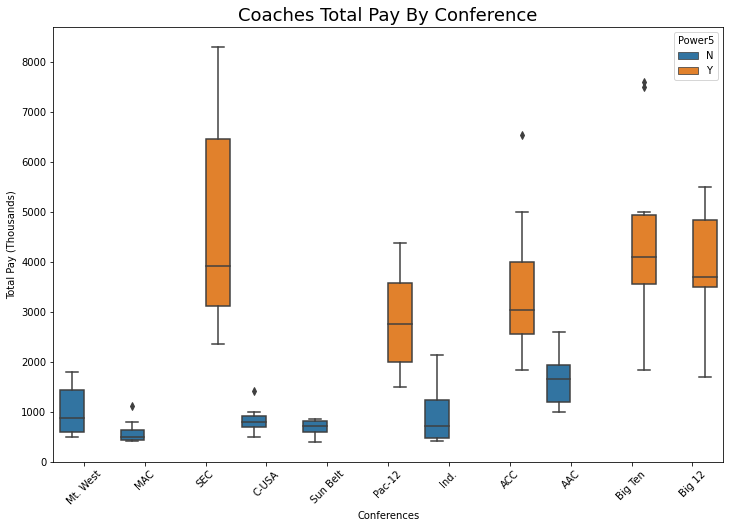

In [0]:
# Create Boxplots By Conference
plt.figure(figsize=(12,8))
coachesbox = sns.boxplot(x="Conference",
                         y="TotalPayThousands",
                         data=finalcoaches,
                         hue="Power5")

#add title, xlabel and y label
plt.title('Coaches Total Pay By Conference', fontsize = 18)
plt.xlabel('Conferences')
plt.ylabel('Total Pay (Thousands)')
#rotate day of week (dow) names to reduce overlap
coachesbox.set_xticklabels(coachesbox.get_xticklabels(),rotation=45)
plt.show()

Text(0, 0.5, 'Total Pay (Thousands)')

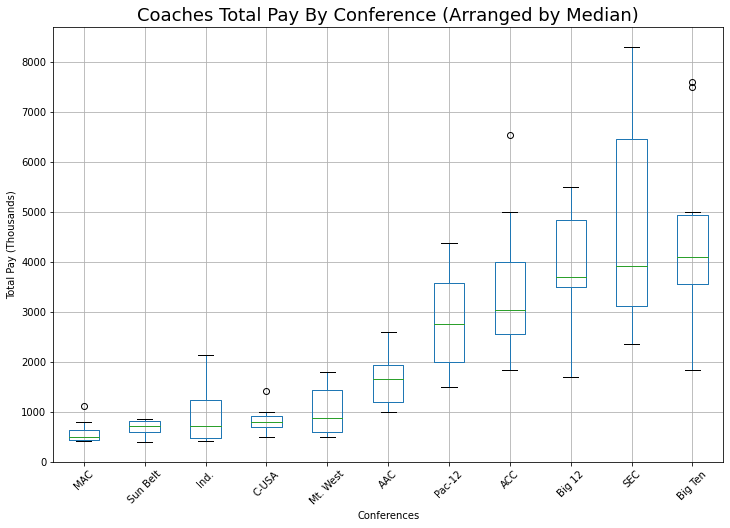

In [0]:
#https://stackoverflow.com/questions/21912634/how-can-i-sort-a-boxplot-in-pandas-by-the-median-values

plt.figure(figsize=(12,8))

def boxplot_sorted(df, by, column):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values(ascending=True)
  df2[meds.index].boxplot(rot=45)

boxplot_sorted(finalcoaches, by=["Conference"], column="TotalPayThousands")
plt.title('Coaches Total Pay By Conference (Arranged by Median)', fontsize = 18)
plt.xlabel('Conferences')
plt.ylabel('Total Pay (Thousands)')

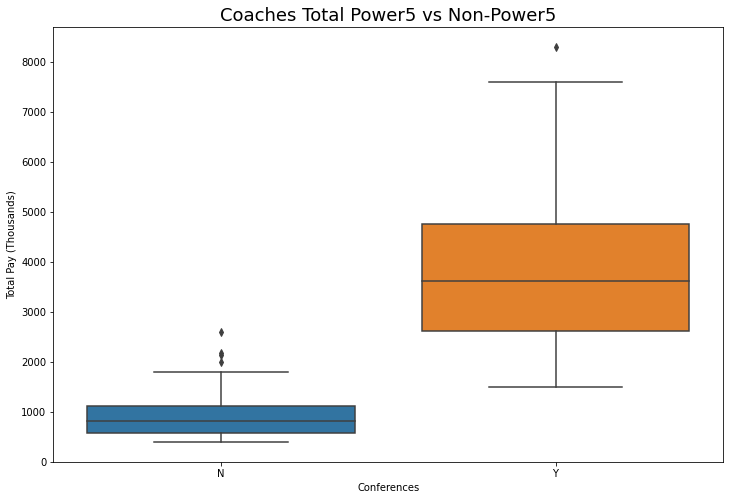

In [0]:
# Create Boxplots By Conference
plt.figure(figsize=(12,8))
coachesbox2 = sns.boxplot(x="Power5",
                         y="TotalPayThousands",
                         data=finalcoaches
                         )

#add title, xlabel and y label
plt.title('Coaches Total Power5 vs Non-Power5', fontsize = 18)
plt.xlabel('Conferences')
plt.ylabel('Total Pay (Thousands)')
#rotate day of week (dow) names to reduce overlap
coachesbox.set_xticklabels(coachesbox.get_xticklabels(),rotation=45)
plt.show()

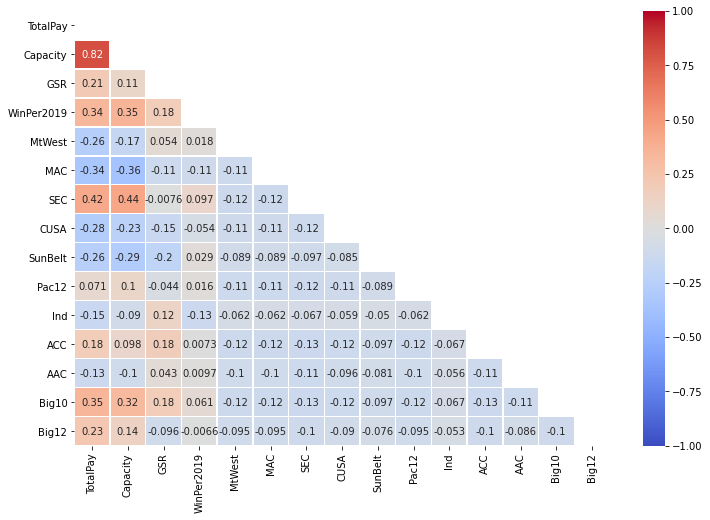

In [0]:
# Check Correlation Matrix
coachescorr = finalcoaches.drop(['AssistantPay', 'Cohort Year', 'SchoolPay', 'Bonus', 'BonusPaid',
                                 'Buyout', 'TotalPayThousands', 'FGR'], axis=1)
# create corr df
corr = coachescorr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Print heatmap
plt.figure(figsize=(12,8))
sns.heatmap(coachescorr.corr(), mask=mask,annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',
           linewidths=.5 #, linecolor='black'
           )

# Print values
#print(coachescorr.corr())                                               

Text(0.5, 0.98, 'Total Pay vs. Capacity, GSR, 2019 Win Percentage')

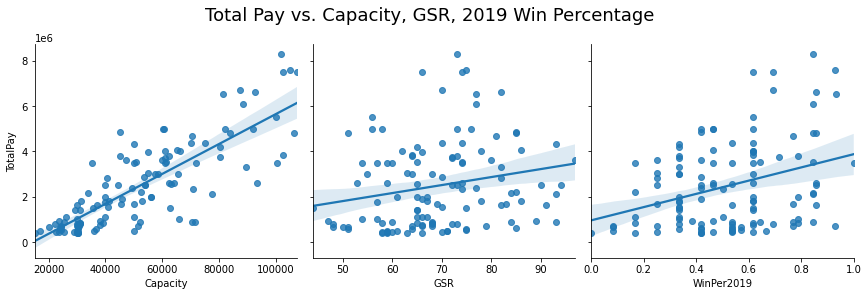

In [0]:
# Plot Total Pay vs Capacity, GSR, Win Percentage(2019)
# visualize the relationship between the features and the response using scatterplots
g=sns.pairplot(finalcoaches, x_vars=['Capacity','GSR','WinPer2019'],
             y_vars='TotalPay', height=4, aspect=1, kind='reg'
              )
#plt.title('Total Pay vs. Capacity, GSR, 2019 Win Percentage', y=4, fontsize = 16)
plt.subplots_adjust(top=.85)
g.fig.suptitle('Total Pay vs. Capacity, GSR, 2019 Win Percentage',fontsize = 18)

Text(0.5, 0.98, 'Total Pay vs. Capacity, GSR, 2019 Win Percentage')

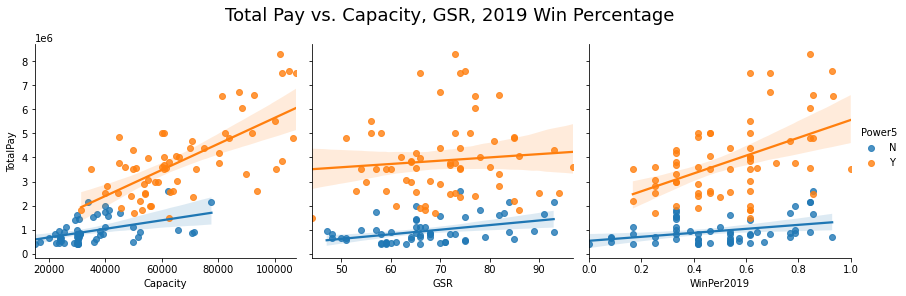

In [0]:
# Plot Total Pay vs Capacity, GSR, Win Percentage(2019)
# visualize the relationship between the features and the response using scatterplots
g=sns.pairplot(finalcoaches, x_vars=['Capacity','GSR','WinPer2019'], hue="Power5",
             y_vars='TotalPay', height=4, aspect=1, kind='reg'
              )
#plt.title('Total Pay vs. Capacity, GSR, 2019 Win Percentage', y=4, fontsize = 16)
plt.subplots_adjust(top=.85)
g.fig.suptitle('Total Pay vs. Capacity, GSR, 2019 Win Percentage',fontsize = 18)

Text(0.5, 0.98, 'Total Pay vs. Capacity, GSR, 2019 Win Percentage')

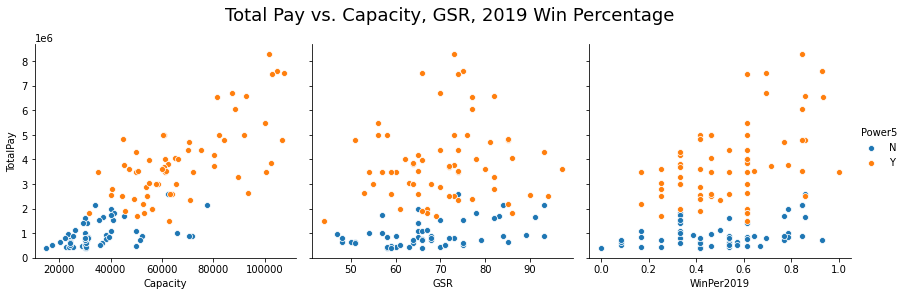

In [0]:
# Plot Total Pay vs Capacity, GSR, Win Percentage(2019)
# visualize the relationship between the features and the response using scatterplots
g=sns.pairplot(finalcoaches, x_vars=['Capacity','GSR','WinPer2019'], hue="Power5",
             y_vars='TotalPay', height=4, aspect=1,
              )
#plt.title('Total Pay vs. Capacity, GSR, 2019 Win Percentage', y=4, fontsize = 16)
plt.subplots_adjust(top=.85)
g.fig.suptitle('Total Pay vs. Capacity, GSR, 2019 Win Percentage',fontsize = 18)

Text(0.5, 0.98, 'Total Pay vs. Capacity (by Conference)')

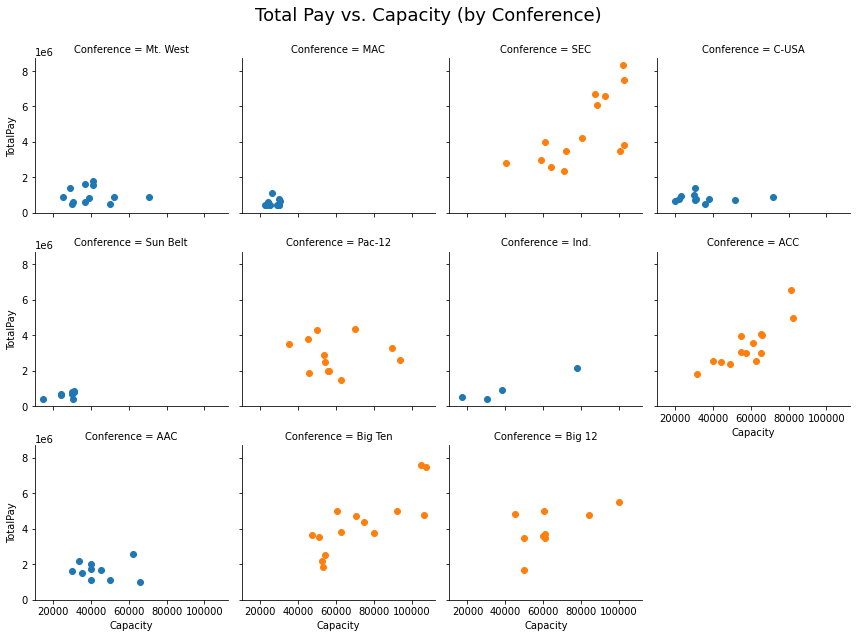

In [0]:
#print("Total Pay vs. Capacity by Conference")
g = sns.FacetGrid(finalcoaches, col="Conference", col_wrap=4, hue="Power5", )
g.map(plt.scatter, "Capacity","TotalPay", alpha=1);
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Pay vs. Capacity (by Conference)',fontsize = 18)

Text(0.5, 0.98, 'Total Pay vs. GSR (by Conference)')

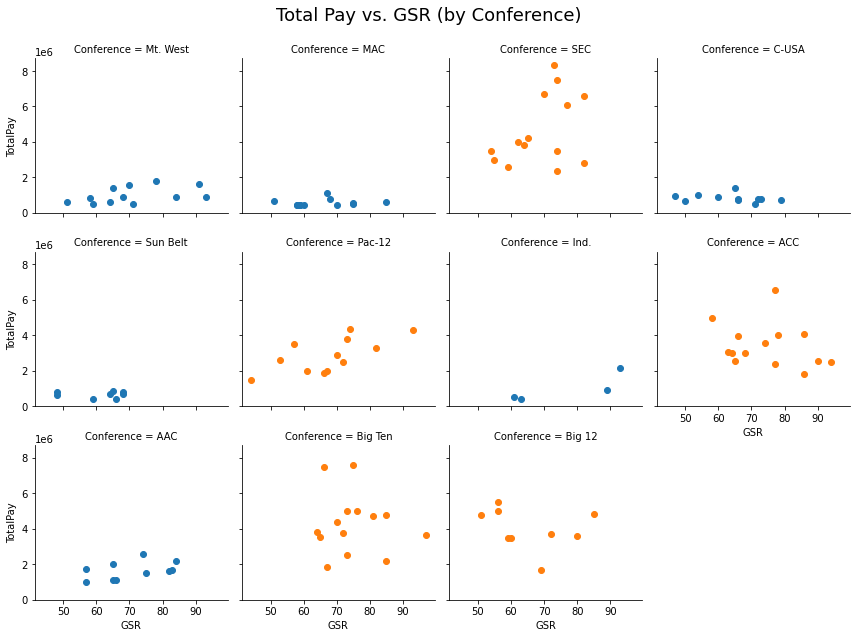

In [0]:
#print("Total Pay vs. Capacity by Conference")
g = sns.FacetGrid(finalcoaches, col="Conference", col_wrap=4, hue="Power5")
g.map(plt.scatter, "GSR","TotalPay", alpha=1);
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Pay vs. GSR (by Conference)',fontsize = 18)

Text(0.5, 0.98, 'Total Pay vs. 2019 Win Percentage (by Conference)')

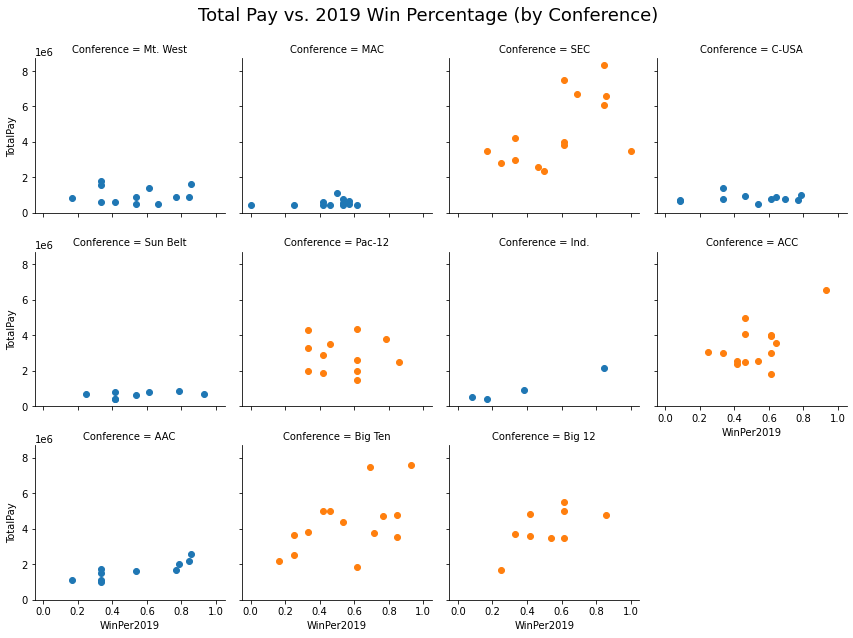

In [0]:
#print("Total Pay vs. Capacity by Conference")
g = sns.FacetGrid(finalcoaches, col="Conference", col_wrap=4, hue="Power5")
g.map(plt.scatter, "WinPer2019","TotalPay", alpha=1);
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Pay vs. 2019 Win Percentage (by Conference)',fontsize = 18)

### Create Test/Train sets

In [0]:
# employ training-and-test regimen for model validation
np.random.seed(1234)
finalcoaches['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(finalcoaches))
finalcoaches_train = finalcoaches[finalcoaches['runiform'] >= 0.33]
finalcoaches_test = finalcoaches[finalcoaches['runiform'] < 0.33]

# check training data frame
print("*"*80)
print('\nfinalcoaches_train data frame (rows, columns): ',finalcoaches_train.shape)
print("*"*80)
print(finalcoaches_train.head())

# check test data frame
print("*"*80)
print('\nfinalcoaches_test data frame (rows, columns): ',finalcoaches_test.shape)
print("*"*80)
print(finalcoaches_test.head())

********************************************************************************

finalcoaches_train data frame (rows, columns):  (86, 31)
********************************************************************************
                  School Conference              Coach  ...  Big10  Big12  runiform
1                  Akron        MAC       Terry Bowden  ...      0      0  0.622109
2                Alabama        SEC         Nick Saban  ...      0      0  0.437728
3  Alabama at Birmingham      C-USA         Bill Clark  ...      0      0  0.785359
4      Appalachian State   Sun Belt  Scott Satterfield  ...      0      0  0.779976
7               Arkansas        SEC        Chad Morris  ...      0      0  0.801872

[5 rows x 31 columns]
********************************************************************************

finalcoaches_test data frame (rows, columns):  (34, 31)
********************************************************************************
             School Conference    

### Model 1: With Conference + Capacity + WinPer2019 + GSR

In [0]:
# specify a simple model with Team Conference
conference_model = str('TotalPay ~ SEC + CUSA + SunBelt + Pac12 + Ind + ACC + AAC + Big10 + Big12 + MtWest + MAC + Capacity + WinPer2019 + GSR')

# fit the model to the training set
train_confmodel_fit = smf.ols(conference_model, data = finalcoaches_train).fit()

# summary of model fit to the training set
print(train_confmodel_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     23.60
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           7.22e-21
Time:                        03:27:52   Log-Likelihood:                -1295.2
No. Observations:                  86   AIC:                             2618.
Df Residuals:                      72   BIC:                             2653.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.591e+06   7.73e+05     -2.059      0.0

### Model 2: Model 1 w/ no Conference

In [0]:
# specify a simple model with Team Conference
elite_model = str('TotalPay ~ Capacity + WinPer2019 + GSR')

# fit the model to the training set
train_elitemodel_fit = smf.ols(elite_model, data = finalcoaches_train).fit()
# summary of model fit to the training set
print("*"*80)
print(train_elitemodel_fit.summary())

********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     70.81
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.08e-22
Time:                        03:27:52   Log-Likelihood:                -1311.6
No. Observations:                  86   AIC:                             2631.
Df Residuals:                      82   BIC:                             2641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

### Model 3: Model 1 + State

In [0]:
# specify a simple model with Team Conference
state_model = str('TotalPay ~ Conference + Capacity + WinPer2019 + GSR + State')

# fit the model to the training set
train_stmodel_fit = smf.ols(state_model, data = finalcoaches_train).fit()
# summary of model fit to the training set
print("*"*80)
print(train_stmodel_fit.summary())

********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     9.407
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           2.18e-11
Time:                        03:27:53   Log-Likelihood:                -1263.1
No. Observations:                  86   AIC:                             2616.
Df Residuals:                      41   BIC:                             2727.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Model 4: Model 2 + State

In [0]:
# specify a simple model with Team Conference
statenoconf_model = str('TotalPay ~ Capacity + WinPer2019 + GSR + State')

# fit the model to the training set
train_statenoconfmodel_fit = smf.ols(statenoconf_model, data = finalcoaches_train).fit()
# summary of model fit to the training set
print("*"*80)
print(train_statenoconfmodel_fit.summary())

********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     7.147
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           3.20e-10
Time:                        03:27:53   Log-Likelihood:                -1289.5
No. Observations:                  86   AIC:                             2651.
Df Residuals:                      50   BIC:                             2739.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### We will use model 1

In [0]:
# specify a simple model with Team Conference
conference_model = str('TotalPay ~ SEC + CUSA + SunBelt + Pac12 + Ind + ACC + AAC + Big10 + Big12 + MtWest + MAC + Capacity + WinPer2019 + GSR')

# fit the model to the training set
train_confmodel_fit = smf.ols(conference_model, data = finalcoaches_train).fit()

# summary of model fit to the training set
print(train_confmodel_fit.summary())

# print the coefficients
print(train_confmodel_fit.params)

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     23.60
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           7.22e-21
Time:                        03:27:53   Log-Likelihood:                -1295.2
No. Observations:                  86   AIC:                             2618.
Df Residuals:                      72   BIC:                             2653.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.591e+06   7.73e+05     -2.059      0.0

In [0]:
# Help from : https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

#Test & Train
#finalcoaches_train
#finalcoaches_test

#linearRegression from SKlearn
lin_reg = LinearRegression()

# train
y_train = finalcoaches_train[['TotalPay']]
X_train = finalcoaches_train[['Capacity', 'GSR', 'WinPer2019', 'SEC', 'CUSA', 'SunBelt', 'Pac12', 'Ind', 'ACC',
                              'AAC', 'Big10', 'Big12', 'MtWest', 'MAC']]
lin_reg.fit(X_train, y_train)
                             

#Predict
y_test = finalcoaches_test[['TotalPay']]
X_test = finalcoaches_test[['Capacity', 'GSR', 'WinPer2019', 'SEC', 'CUSA', 'SunBelt', 'Pac12', 'Ind', 'ACC',
                              'AAC', 'Big10', 'Big12', 'MtWest', 'MAC']]
y_pred = lin_reg.predict(X_test)

In [0]:
#convert floats to dollars
#https://stackoverflow.com/questions/21208376/converting-float-to-dollars-and-cents


#!pip install locale # if not installed already
import locale
locale.setlocale(locale.LC_ALL, '')
#locale.setlocale( locale.LC_ALL, 'English_United States.1252' )
#locale.currency( 1234.50, grouping = True )

'en_US.UTF-8'

In [0]:
# predict syracuse salary
syr = finalcoaches[finalcoaches['School'] == 'Syracuse']
lin_reg.predict(syr[['Capacity', 'GSR', 'WinPer2019', 'SEC', 'CUSA', 'SunBelt', 'Pac12', 'Ind', 'ACC',
                              'AAC', 'Big10', 'Big12', 'MtWest', 'MAC']])

syrpred = lin_reg.predict(syr[['Capacity', 'GSR', 'WinPer2019', 'SEC', 'CUSA', 'SunBelt', 'Pac12', 'Ind', 'ACC',
                              'AAC', 'Big10', 'Big12', 'MtWest', 'MAC']])


# print amount
print("Syracuse Coach Pay should be ",(locale.currency( syrpred, grouping = True )))

Syracuse Coach Pay should be  $2,921,754.10


In [0]:
# Predict Big East (Using AAC) Pay
print(train_confmodel_fit.params)
print(train_confmodel_fit.params[7]) #Coefficiant for AAC
print("*"*80)
acccoef = train_confmodel_fit.params[6]
aaccoef = train_confmodel_fit.params[7]
print("Syracuse Coach Big East Pay should be ",(locale.currency( ((syrpred-acccoef) +aaccoef), grouping = True )))

Intercept    -1.591071e+06
SEC           1.175190e+06
CUSA         -8.396895e+05
SunBelt      -6.237114e+05
Pac12         3.165260e+05
Ind          -1.785427e+06
ACC           4.487025e+05
AAC          -4.176068e+05
Big10         6.661372e+05
Big12         1.087409e+06
MtWest       -9.012773e+05
MAC          -7.173237e+05
Capacity      4.161636e+01
WinPer2019    9.854898e+05
GSR           2.082555e+04
dtype: float64
-417606.842689804
********************************************************************************
Syracuse Coach Big East Pay should be  $2,055,444.71


In [0]:
# Predict Big10 Pay
print(train_confmodel_fit.params)
print(train_confmodel_fit.params[8]) #Coefficiant for Big10
btencoef = train_confmodel_fit.params[8]
print("*"*80)
print("Syracuse Coach Big Ten Pay should be ",(locale.currency( ((syrpred -acccoef) + btencoef ), grouping = True )))

Intercept    -1.591071e+06
SEC           1.175190e+06
CUSA         -8.396895e+05
SunBelt      -6.237114e+05
Pac12         3.165260e+05
Ind          -1.785427e+06
ACC           4.487025e+05
AAC          -4.176068e+05
Big10         6.661372e+05
Big12         1.087409e+06
MtWest       -9.012773e+05
MAC          -7.173237e+05
Capacity      4.161636e+01
WinPer2019    9.854898e+05
GSR           2.082555e+04
dtype: float64
666137.2201025379
********************************************************************************
Syracuse Coach Big Ten Pay should be  $3,139,188.77


In [0]:
finalcoaches[finalcoaches['School'].str.match('Syracuse')]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,Capacity,Cohort Year,State,GSR,FGR,Win-Loss Record2019,WinPercentage2019,WinPer2019,TotalPayThousands,Power5,MtWest,MAC,SEC,CUSA,SunBelt,Pac12,Ind,ACC,AAC,Big10,Big12,runiform
102,Syracuse,ACC,Dino Babers,2401206.0,2401206.0,0.0,0.0,0.0,0.0,49250.0,2006.0,NY,77.0,64.0,5-7-0,41.7%,0.417,2401.206,Y,0,0,0,0,0,0,0,1,0,0,0,0.480359
